In [1]:
import sys
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image

import tensorflow as tf

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam #try different optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [2]:
import os
import numpy as np

from tqdm import tqdm_notebook, tnrange

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
# Set some parameters
im_width = 512
im_height = 512 
border = 5

In [4]:
#fnX ='./npy files/X_train512_35imgs_V4.npy'
#fnY ='./npy files/y_train512_35imgs_V4.npy'
#fnX ='./npy files/X_train512_35imgs_noText.npy'
#fnY ='./npy files/y_train512_35imgs_noText.npy'
#fnX ='./npy files/X_train512_46imgs_noText.npy'
#fnY ='./npy files/y_train512_46imgs_noText.npy'
fnX ='./npy files/X_train512_46imgs_noTextMag.npy'
fnY ='./npy files/y_train512_46imgs_noTextMag.npy'

X = np.load(fnX)
y = np.load(fnY)

print(len(X))

data_train, data_val, masks_train, masks_val = train_test_split(X, y, test_size=0.20, random_state = 156)
print(len(data_train))
print(len( masks_train))

46
36
36


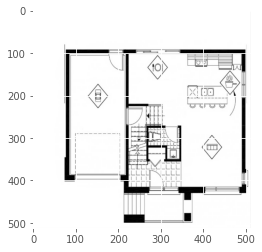

In [5]:
ix = random.randint(0, len(data_val)-1)
image = data_val[ix]
imgplot = plt.imshow(image)
plt.show()

In [6]:
print(len(data_train))
print(data_train[0].shape)
print(masks_train[0].shape)

36
(512, 512, 3)
(512, 512, 3)


32
hi


[None, None]

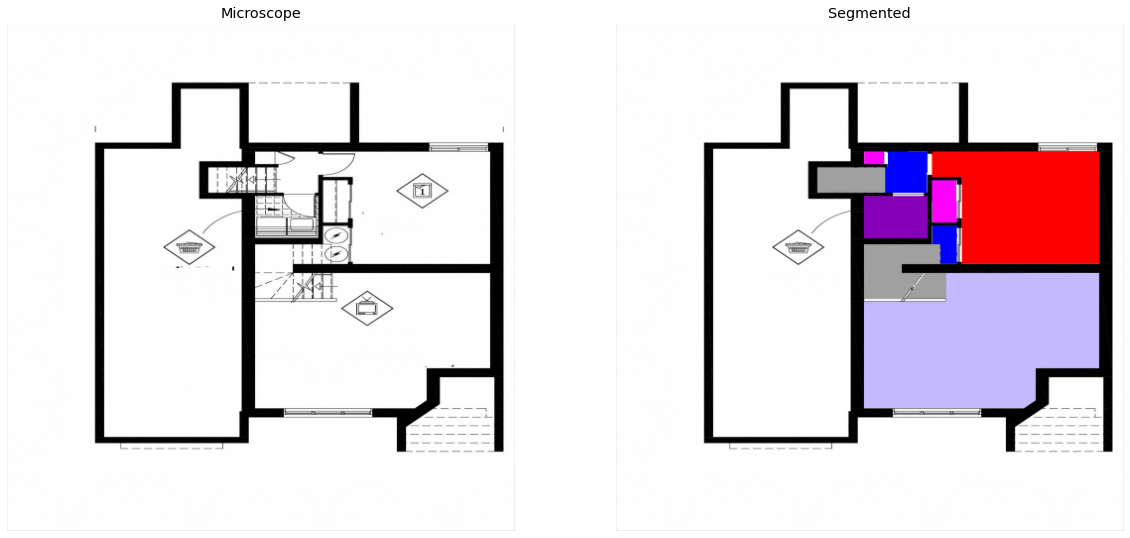

In [7]:
# Check if training data looks all right
#print(len(data_train))
#print(len(masks_train))
ix = random.randint(0, len(data_train)-1)
#ix = 23
print(ix)
has_mask = masks_train[ix].max() > 0
#print(y_train[ix].max())
#print(y_train[ix])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(data_train[ix])
if has_mask:
    print("hi")
    #ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Microscope')

ax[1].imshow(masks_train[ix])
ax[1].set_title('Segmented');
[axi.set_axis_off() for axi in ax.ravel()]

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [9]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    print(dropout
         
         )
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
my_lr = 0.0065
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)

model.compile(optimizer=Adam(lr = my_lr), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

    

0.2
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
___________________________________________________________________________________

In [11]:
#saveName = 'Unet512_Color Coding_26FloorPlans V1Y lr_' + str(my_lr).split('.')[1]
#model.load_weights('./modelCheckpoint/Unet512 35FloorPlans V7 retrain V1Y lr_001.h5')
#model.load_weights('./modelCheckpoint/Unet512 46FloorPlans no_text V2 retrain V7 retrain V1Y lr002 .h5')
saveName = 'Unet512 46FloorPlans noTextMag V1 retrain ' 
checkpoint_filepath = "./modelCheckpoint/"+saveName + ".h5"
model.load_weights(checkpoint_filepath)
print(checkpoint_filepath)

./modelCheckpoint/Unet512 46FloorPlans noTextMag V1 retrain .h5


In [203]:
callbacks = [
    EarlyStopping(monitor="val_loss",patience=50,verbose=1),
    ReduceLROnPlateau(monitor="val_loss",factor=0.95, patience=10, min_lr=0.001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True, verbose=1)
]

In [204]:
results = model.fit(data_train, masks_train, batch_size=8,epochs=500, callbacks=callbacks,
                    validation_data=(data_val, masks_val))

Epoch 1/500
5/5 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.5164 
Epoch 00001: val_loss improved from inf to 0.13876, saving model to ./modelCheckpoint\Unet512 46FloorPlans noTextMag V1 retrain .h5
5/5 [==============================] - 200s 40s/step - loss: 0.1310 - accuracy: 0.5164 - val_loss: 0.1388 - val_accuracy: 0.5963
Epoch 2/500
5/5 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.5365 
Epoch 00002: val_loss did not improve from 0.13876
5/5 [==============================] - 143s 29s/step - loss: 0.1238 - accuracy: 0.5365 - val_loss: 0.2323 - val_accuracy: 0.5085
Epoch 3/500
5/5 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.6581 
Epoch 00003: val_loss did not improve from 0.13876
5/5 [==============================] - 61s 12s/step - loss: 0.1191 - accuracy: 0.6581 - val_loss: 0.1684 - val_accuracy: 0.4724
Epoch 4/500
5/5 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.6015
Epoch

Epoch 30/500
5/5 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.5537 
Epoch 00030: val_loss did not improve from 0.10287
5/5 [==============================] - 51s 10s/step - loss: 0.0996 - accuracy: 0.5537 - val_loss: 0.2236 - val_accuracy: 0.2251
Epoch 31/500
5/5 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.6104 
Epoch 00031: val_loss did not improve from 0.10287
5/5 [==============================] - 50s 10s/step - loss: 0.0983 - accuracy: 0.6104 - val_loss: 0.2019 - val_accuracy: 0.2537
Epoch 32/500
5/5 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.6338
Epoch 00032: val_loss did not improve from 0.10287
5/5 [==============================] - 49s 10s/step - loss: 0.0984 - accuracy: 0.6338 - val_loss: 0.1717 - val_accuracy: 0.2879
Epoch 33/500
5/5 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.5724 
Epoch 00033: val_loss did not improve from 0.10287
5/5 [============================

Epoch 60/500
5/5 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.5845 
Epoch 00060: val_loss did not improve from 0.10287
5/5 [==============================] - 114s 23s/step - loss: 0.0948 - accuracy: 0.5845 - val_loss: 0.2867 - val_accuracy: 0.2156
Epoch 61/500
5/5 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.6067 
Epoch 00061: val_loss did not improve from 0.10287
5/5 [==============================] - 99s 20s/step - loss: 0.0947 - accuracy: 0.6067 - val_loss: 0.2300 - val_accuracy: 0.2356
Epoch 62/500
5/5 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.5875 
Epoch 00062: val_loss did not improve from 0.10287
5/5 [==============================] - 265s 53s/step - loss: 0.0948 - accuracy: 0.5875 - val_loss: 0.1983 - val_accuracy: 0.2479
Epoch 63/500
5/5 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.5571
Epoch 00063: val_loss did not improve from 0.10287
5/5 [==========================

In [13]:
fn =  "./modelCheckpoint/"+saveName + "_results.npy"
#np.save(fn,  results.history)

In [15]:
results = np.load(fn, allow_pickle=True)

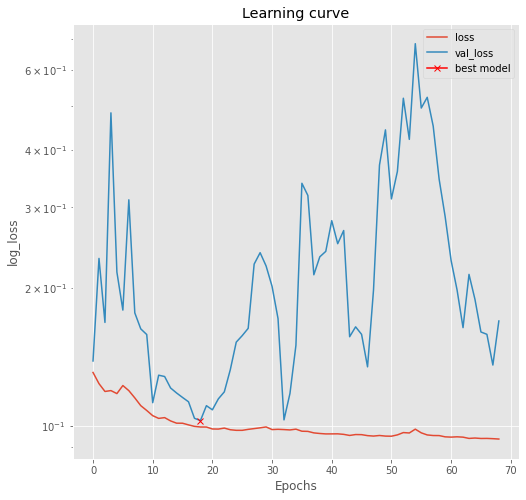

In [20]:

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
#plt.plot(results.history["lr"][40:], label="lr")
plt.plot(results.item()["loss"], label="loss")
plt.plot(results.item()["val_loss"], label="val_loss")
plt.plot( np.argmin(results.item()["val_loss"]), np.min(results.item()["val_loss"]), marker="x", color="r", label="best model")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig("./image/test/output/LC_" +saveName +".jpg")


In [21]:
X_train = data_train
y_train = masks_train
print(data_train.shape)

(36, 512, 512, 3)


In [22]:
prediction =model.predict(data_train, verbose=1)

2/2 [==============================] - 3s 1s/step


11


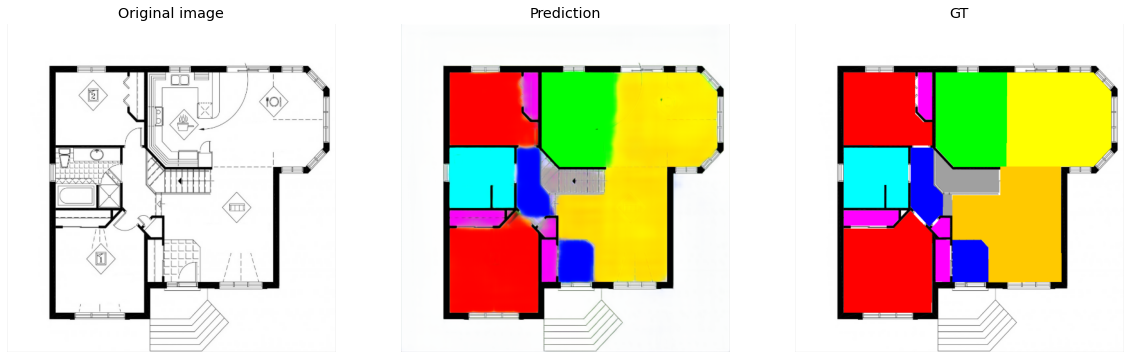

In [23]:
i = random.randint(0, len(X_train)-1)
print(i)
#print(xTest512names[i])
original = data_train[i]
pred = prediction[i]

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax[0].imshow(original)

ax[0].set_title('Original image')

ax[1].imshow(pred)
ax[1].set_title('Prediction')

ax[2].imshow(y_train[i])
ax[2].set_title('GT')


[axi.set_axis_off() for axi in ax.ravel()]
plt.savefig("./image/test/output/" +saveName +"_" + str(i)+".jpg")


In [24]:
#X_test = np.load('./npy files/X_test512_13imgs_noText.npy')
X_test = np.load('./npy files/X_test512_14imgs_noText.npy')
prediction =model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 22ms/step


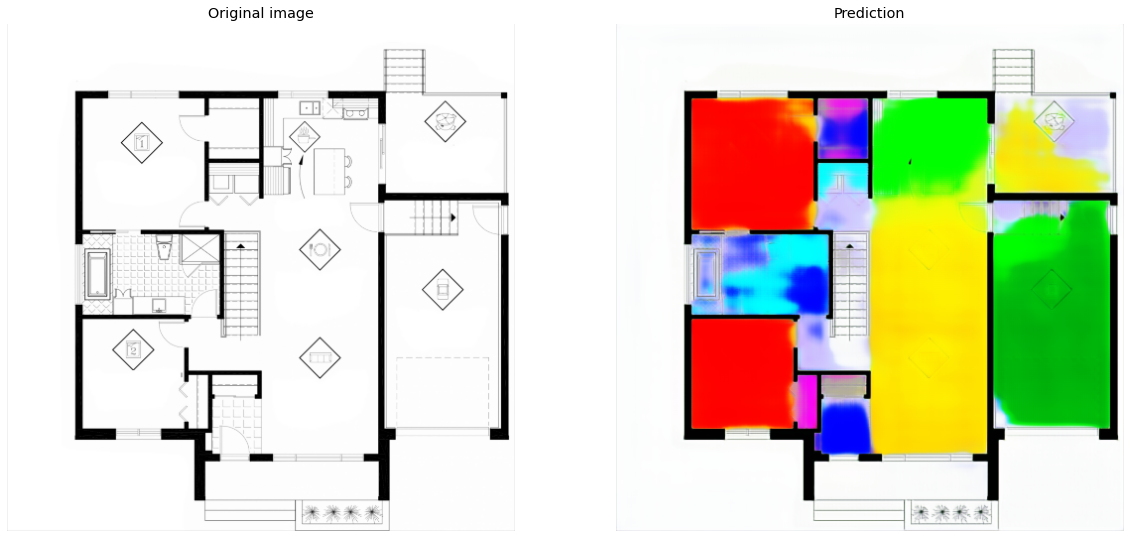

In [28]:
i = random.randint(0, len(X_test)-1)
#print(xTest512names[i])
original = X_test[i]
pred = prediction[i]

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(original)

ax[0].set_title('Original image')

ax[1].imshow(pred)
ax[1].set_title('Prediction')

#ax[2].imshow(y_train[i])
#ax[2].set_title('GT')


[axi.set_axis_off() for axi in ax.ravel()]
plt.savefig("./image/test/output/" +saveName +"_" + str(i)+".jpg")